# Using pre-trained word embeddings


## Setup

In [1]:
import os
os.environ["XLA_FLAGS"]='--xla_gpu_cuda_data_dir=/usr/lib/cuda'
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers
import re
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import StratifiedKFold
import pickle

2023-05-25 22:30:23.881954: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 22:30:23.947571: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-25 22:30:24.287612: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-25 22:30:24.287645: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

In [2]:
from natasha import (
    
    NewsEmbedding
)

emb = NewsEmbedding()

In [3]:
random.seed(13)
np.random.seed(7)   
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()       

In [4]:
class Config:
    MAX_LEN = 200 
    BATCH_SIZE = 32
    LR = 0.001
    VOCAB_SIZE = None
    EMBED_DIM = 300 
    NUM_HEAD = 13  
    FF_DIM = 300 
    NUM_LAYERS = 2


config = Config()

In [5]:
def get_model(vectorizer):
    
    #optimizer = keras.optimizers.Adam()
    #optimizer = keras.optimizers.Adagrad()
    optimizer="rmsprop"
    
    voc = vectorizer.get_vocabulary()
    config.VOCAB_SIZE = len(voc)
    word_index = dict(zip(voc, range(len(voc))))
    
    
    num_tokens = config.VOCAB_SIZE + 2
    embedding_dim = config.EMBED_DIM
    hits = 0
    misses = 0

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))
    
    
    embedding_layer = Embedding(
        num_tokens,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False,
    )       

    
    initializer = tf.keras.initializers.Orthogonal()
    
    inputs = keras.Input(shape=(None,), dtype="int32")
    
    embedded_sequences = embedding_layer(inputs)
   
    
    sequence_output_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, 
                                                                   return_sequences=True,
                                                                   kernel_initializer=initializer
                                                                  ))(embedded_sequences)    
    
    sequence_output_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, 
                                                                   return_sequences=True,
                                                                   kernel_initializer=initializer
                                                                  ))(sequence_output_1)
    
    
    sequence_output = layers.LayerNormalization(epsilon=1e-21, 
                                                name="lnn")(sequence_output_1 + \
                                                            sequence_output_2)
    
    
    pooled_avg_sequences = layers.GlobalAveragePooling1D()(sequence_output)
    pooled_max_sequences = layers.GlobalMaxPooling1D()(sequence_output)    
    
    
    features = layers.concatenate([
                                    pooled_avg_sequences, pooled_max_sequences
                                  ], name='encoder_out')


    x = layers.Dense(units=64, activation="relu")(features)
    x = layers.Dense(units=16, activation="relu")(x)    
    
    outputs = layers.Dense(units=2, activation="softmax")(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name="CLSF")
    
    model.compile(
        loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["acc"]
    )
    
    
    
    return model    
    
 

In [6]:
def get_cl_string(data):
    val_len = 210 #165
    dump=[]
    for i in range(0,len(data)):
        string = data['text'].values[i]  

        if type(string) is float:
            string = " "


        if ('-- Аэроклуб'in string) and ("оставил следующее сообщение:" in string):
            start_text = "оставил следующее сообщение:"
            string_new   = string.replace(start_text, "{")
            end_text = "Страница командировки:"
            string_new = string_new.replace(end_text, "}")

            regex = re.compile("\{(.*)\}")
            string_new = regex.findall(string_new)
            if len(string_new) == 0:
                start_text = "оставил следующее сообщение:"
                string_new   = string.replace(start_text, "{")
                end_text = "Страница заказа:"
                string_new = string_new.replace(end_text, "}")

                regex = re.compile("\{(.*)\}")
                string_new = regex.findall(string_new)

                if len(string_new) == 0:
                    start_text = "оставил следующее сообщение:"
                    string_new   = string.replace(start_text, "{")
                    end_text = "-- Аэроклуб"
                    string_new = string_new.replace(end_text, "}")

                    regex = re.compile("\{(.*)\}")
                    string_new = regex.findall(string_new)

            string = string_new[0]



        elif 'Группа поддержки продаж Департамент продаж ПАО « Аэрофлот »'in string:

            string = data['text'].values[0]
            tresh = 'внимание, что запросы необходимо направлять: понедельник – пятница ( с 09:00 до 19:00 ) e - mail EMAIL EMAIL Тел. PHONE ежедневно с 19:00 до 09:00 и выходные дни - 24 часа: e - mail EMAIL EMAIL Тел. PHONE С уважением, NAME NAME Ведущий консультант Отдела по обслуживанию ключевых клиентов компании Аэроклуб Россия, 107113, г. Москва, 3-я Рыбинская ул., д. 18, стр. 22, Бизнес - центр " Буревестник " ( вход со 2-й Рыбинской ул. ) Тел.: PHONE ( 6098 ) EMAIL EMAIL NAME < NAME > Уважаемый NAME, если у Вас возникли отзывы о нашей работе или пожелания по ее улучшению, мы будем рады видеть их по адресу EMAIL EMAIL Ваш отзыв будет направлен руководителям компании Аэроклуб'
            string   = string.replace(tresh, "!")

            tresh = 'ОГОВОРКА ОБ ОГРАНИЧЕНИИ ОТВЕТСТВЕННОСТИ: Данное сообщение с вложениями может содержать конфиденциальную информацию. Если вы не являетесь адресатом, вы не вправе выполнять какие - либо действия с сообщением и вложениями. В таком случае необходимо удалить сообщение и сообщить об этом отправителю.'
            string   = string.replace(tresh, "!")

            string   = string.split('Clients EMAIL Sent:')

            string = re.sub('[^а-яА-Я 0-9]', ' ', string[0])




        else:    
            string = data['text'].values[i]
        if type(string) is float:
            string = " "


        tresh='Пожалуйста, не изменяйте адрес получателя при ответе на это письмо. -- Аэроклуб'        
        string = string.replace(tresh, "!")    

        string   = string.split('Если файл не открывается, скачайте программу')
        string = string[0]



        string   = string.split('Best regards')
        string = string[0]

        string   = string.split('_ _ _ _ _ _ _ _ _ _ _ _ _ _ _')
        string = string[0]


        string = string.lower()
        string   = string.replace('здравствуйте', "ЗДОРОВО!!!")
        string   = string.replace('пожалуйста, не изменяйте адрес получателя при ответе на это письмо', "ПЛИЗ!!!")
        string   = string.replace('гарантировать', "гарант!!!")
        string   = string.replace('сайте', "сайт!!!")
        string   = string.replace('всегда отвечайте', "всегда ответ!!!")
        string   = string.replace('извините', "извини!!!")
        string   = string.replace('ждать', "жду!!!")
        
        dump.append(string)
    return dump


## Let's take a look at the data

Here's a example of what one file contains:

In [7]:
train_data = pd.read_csv('./data/Пример загрузочного файла.csv')
train_data

,id,title,text,label
0,11500,"Re: Ваучер к заказу 4605077: Адажио, Санкт - П...","NAME, добрый день! Прошу Вас включить ранний з...",1
1,11501,RE: обмен билета для NAME NAME с 9 на 11 декабря,"NAME, добрый день, Пожалуйста, переписывайте с...",1
2,11502,RE: а / бронь 6 декабря Самара - Москва - Сама...,"NAME, да, выписываем. NAME Спасибо! NAME With ...",1
3,11503,RE: * * RE: билеты на Майорку * * * External S...,"Скажите, а такой вариант, но дата обратно – 18...",1
4,11504,Re: Ранний заезд.,"NAME, рз в 08:00 стоит 1525 рублей. С уважение...",0
...,...,...,...,...
495,11995,Re: NAME NAME NAME,"Хорошо, берём NAME NAME NAME для iOS < NAME > ...",1
496,11996,RE: [ EXTERNAL ] RE: NAME номер приказа 6289 н...,"NAME, тогда жду до конца дня инфо от вас, как ...",1
497,11997,"RE: Ваучер к заказу 4587374: NAME NAME NAME, N...","Добрый день, NAME Я сразу же пошел поскандалил...",0
498,11998,"RE: Электронный билет: # 421-PASSPORT, NAME NA...","NAME, добрый день. NAME. Пришлите, пожалуйста,...",1


In [8]:
test_data = pd.read_csv('./data/test_data_cleared.csv')
test_samples = get_cl_string(test_data)
test_data

,id,title,text,label
0,11000,"RE: 555-PASSPORT, NAME NAME","NAME NAME. Для дополнительных консультаций, п...",-1
1,11001,Анапа,# # # write your NAME NAME NAME line # # #:: 5...,-1
2,11002,"RE: заявка гост. NAME, Анапа","NAME, добрый вечер! Не получила ваучер, Пионер...",-1
3,11003,"FW: заявка гост. NAME, Анапа",Анна!пионерский NAME NAME Спасибо NAME С уваже...,-1
4,11004,RE: билеты для NAME,"Ок С уважением, NAME NAME Менеджер по организа...",-1
...,...,...,...,...
995,11995,Re: NAME NAME NAME,"Хорошо, берём NAME NAME NAME для iOS < NAME > ...",-1
996,11996,RE: [ EXTERNAL ] RE: NAME номер приказа 6289 н...,"NAME, тогда жду до конца дня инфо от вас, как ...",-1
997,11997,"RE: Ваучер к заказу 4587374: NAME NAME NAME, N...","Добрый день, NAME Я сразу же пошел поскандалил...",-1
998,11998,"RE: Электронный билет: # 421-PASSPORT, NAME NA...","NAME, добрый день. NAME. Пришлите, пожалуйста,...",-1


## Load pre-trained word embeddings

In [9]:
embeddings_index = {}
for word in emb.vocab.words:
    embeddings_index[word] = emb[word]

In [10]:
samples = []
labels = []
for i in range(len(train_data)):
    labels.append(int(train_data['label'].values[i]))
    
samples = get_cl_string(train_data)

In [11]:
# Shuffle the data
seed = 1337
rng = np.random.RandomState(seed)
rng.shuffle(samples)
rng = np.random.RandomState(seed)
rng.shuffle(labels)



0 =====================================================================================


2023-05-25 22:30:27.172907: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-25 22:30:27.191935: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-25 22:30:27.192070: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-25 22:30:27.192711: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuil

Converted 3079 words (2115 misses)


2023-05-25 22:30:30.991183: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-05-25 22:30:31.479832: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-25 22:30:31.482958: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fb1dc020060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-25 22:30:31.482988: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2023-05-25 22:30:31.485631: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-25 22:30:31.534582: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for th

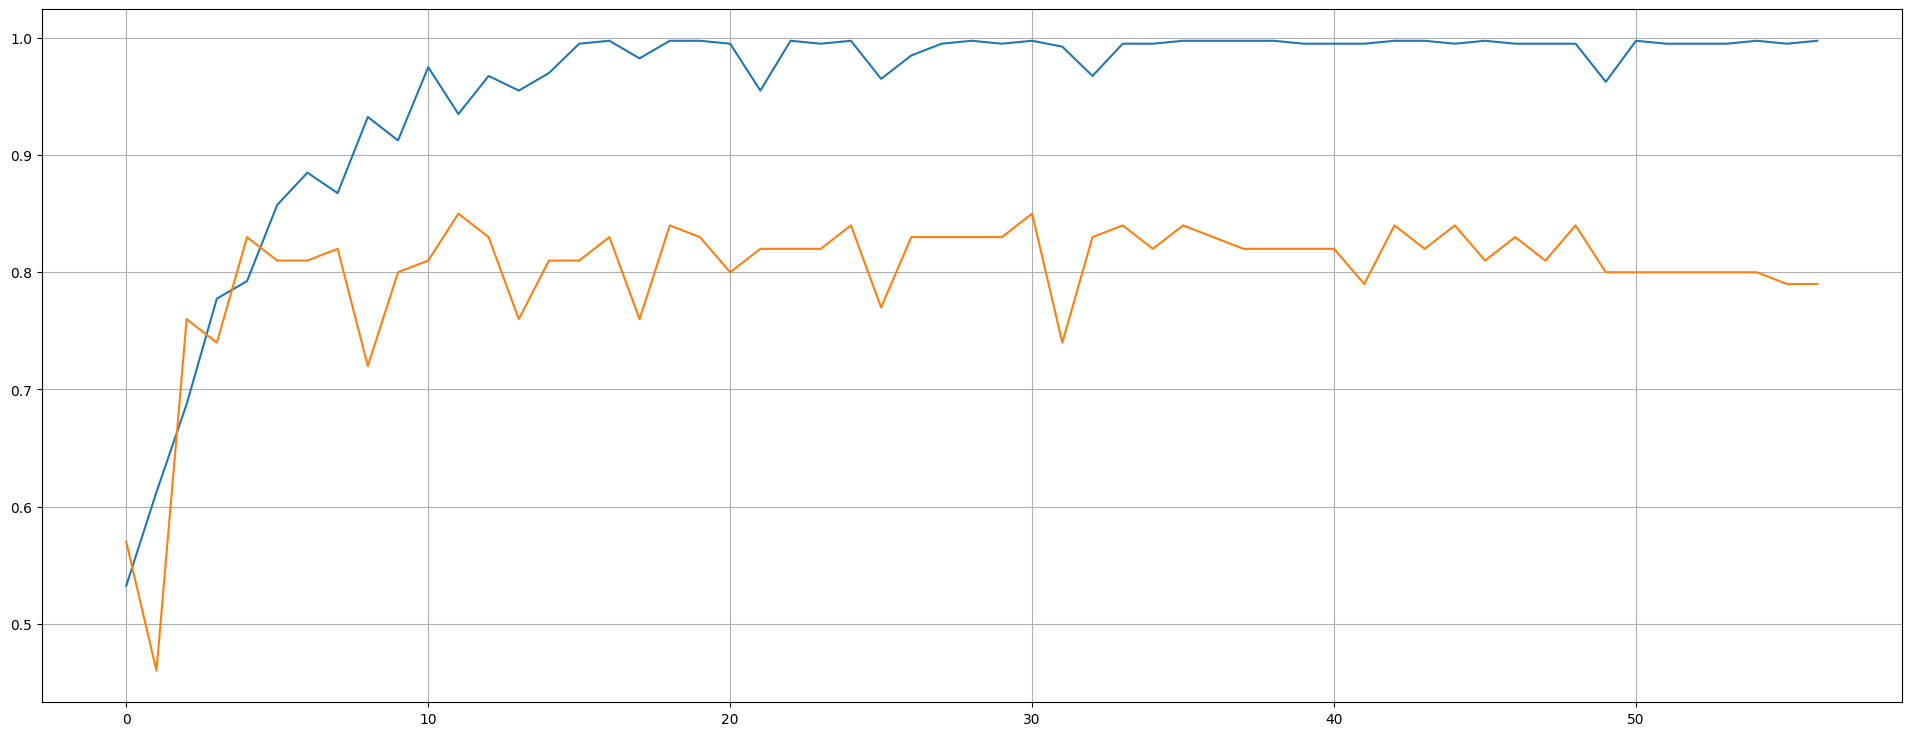

4/4 [==============================] - 1s 9ms/step
f1_score: 0.8192771084337349 acc: 0.85
32/32 [==============================] - 0s 11ms/step


1 =====================================================================================
Converted 2860 words (2007 misses)


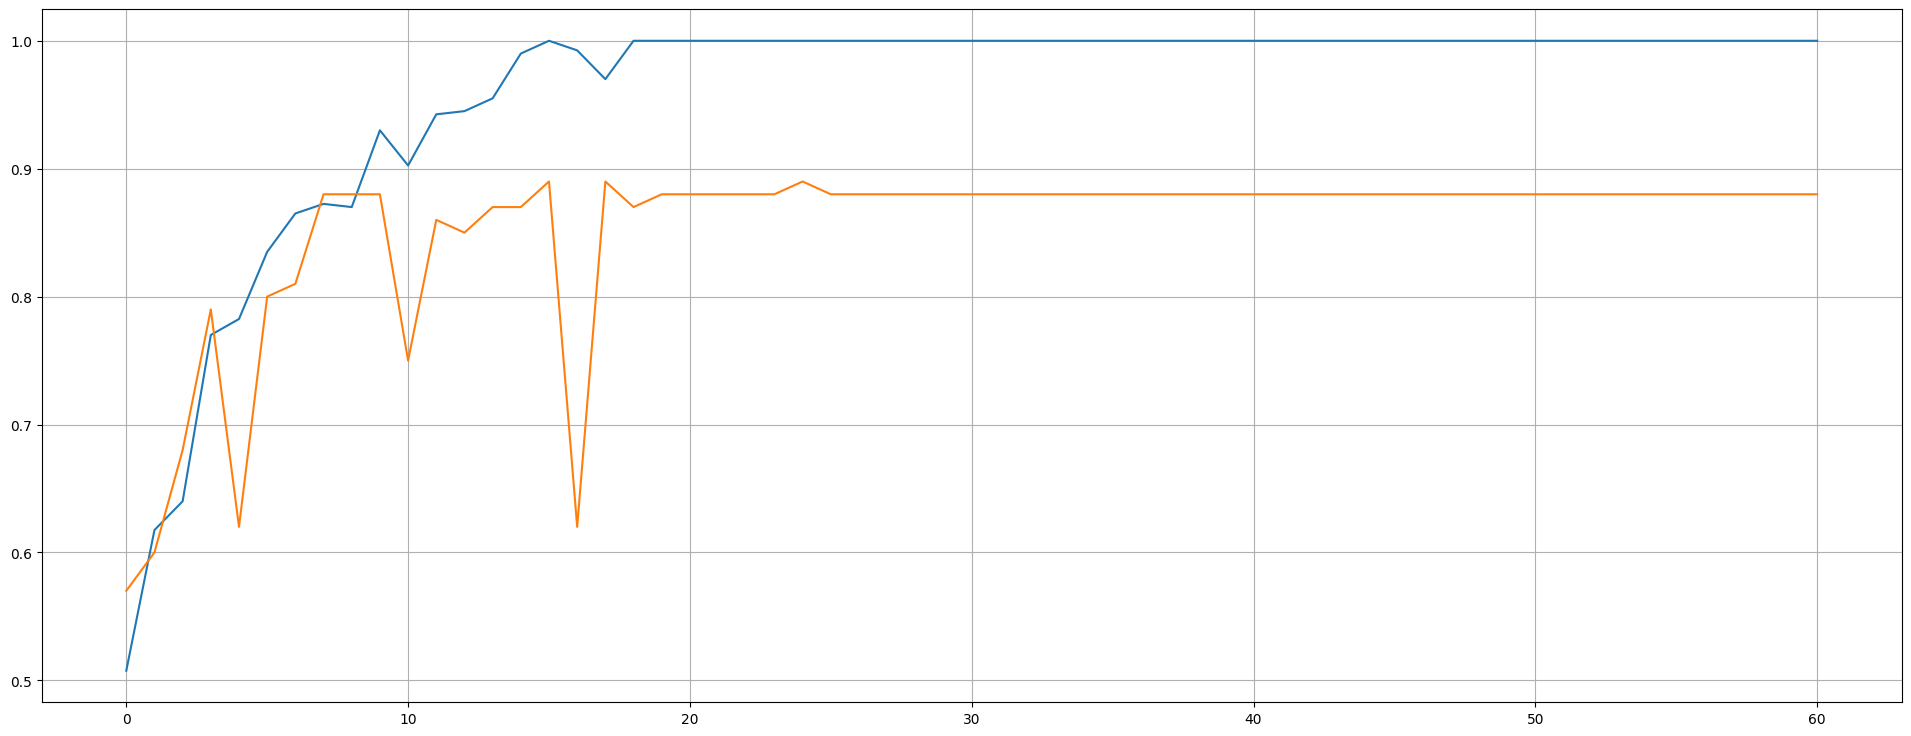

4/4 [==============================] - 1s 10ms/step
f1_score: 0.8791208791208791 acc: 0.89
32/32 [==============================] - 0s 11ms/step


2 =====================================================================================
Converted 2948 words (2078 misses)


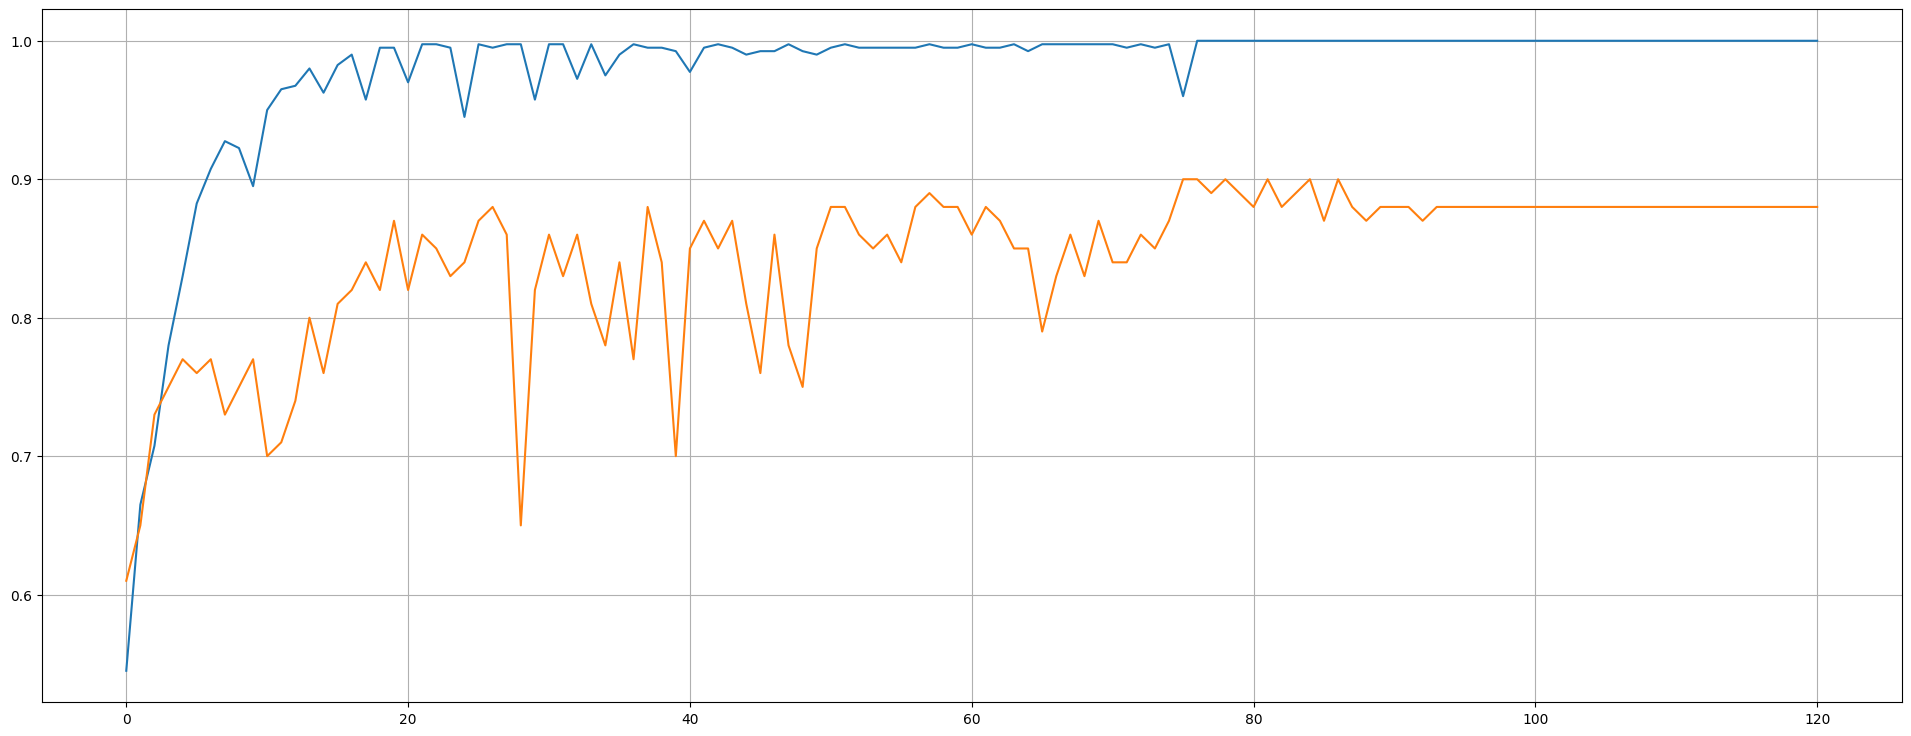

4/4 [==============================] - 1s 10ms/step
f1_score: 0.878048780487805 acc: 0.9
32/32 [==============================] - 0s 11ms/step


3 =====================================================================================
Converted 3019 words (2033 misses)


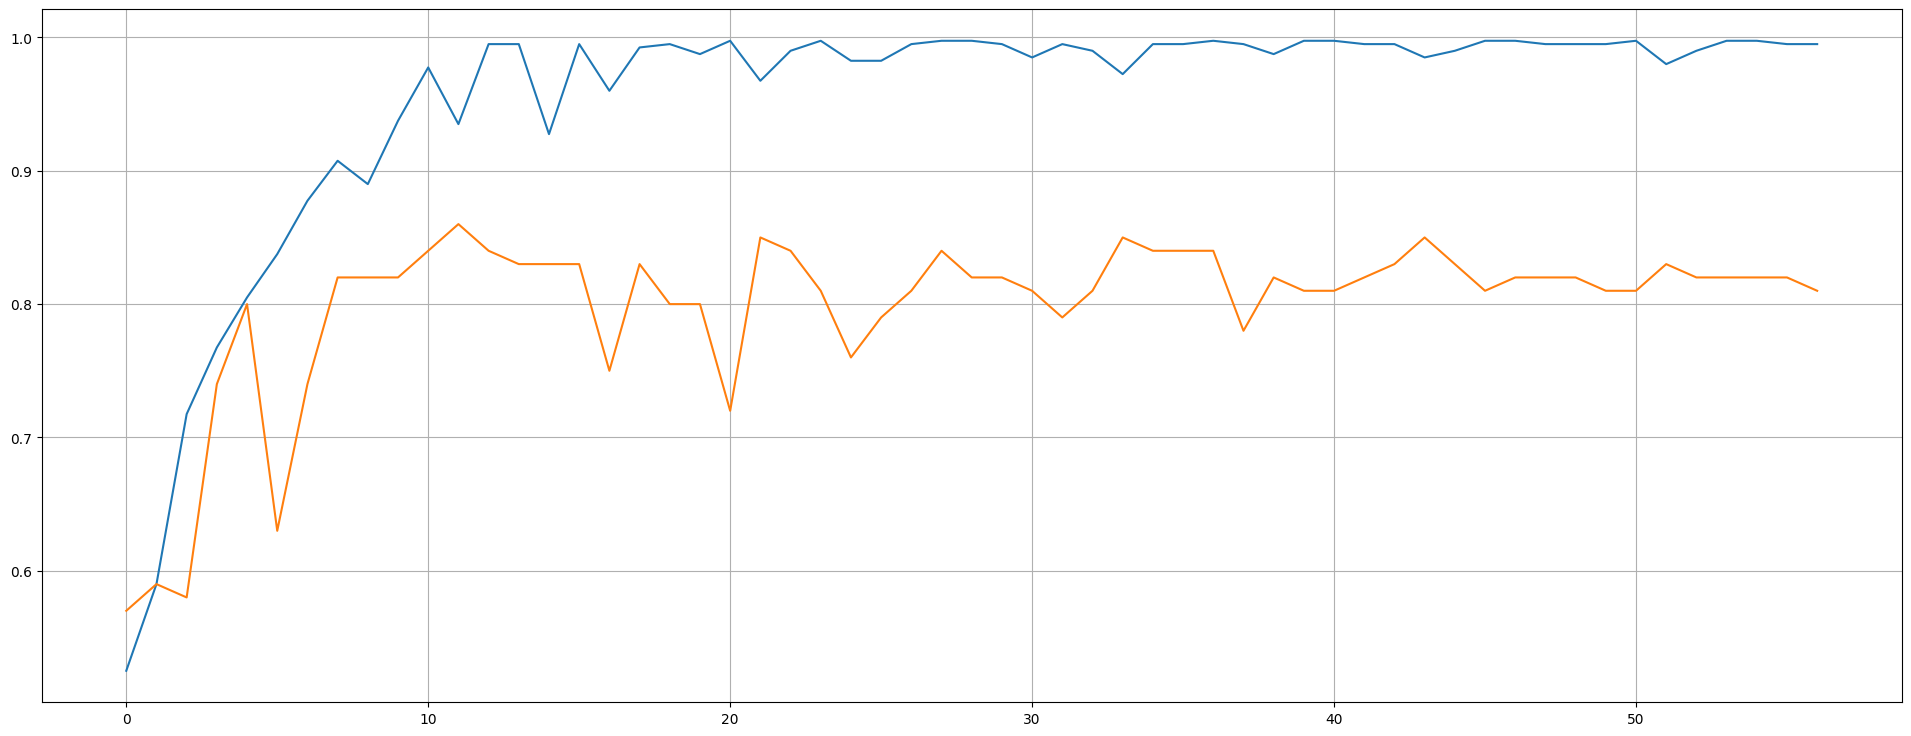

4/4 [==============================] - 1s 10ms/step
f1_score: 0.8292682926829267 acc: 0.86
32/32 [==============================] - 0s 11ms/step


4 =====================================================================================
Converted 2876 words (1946 misses)


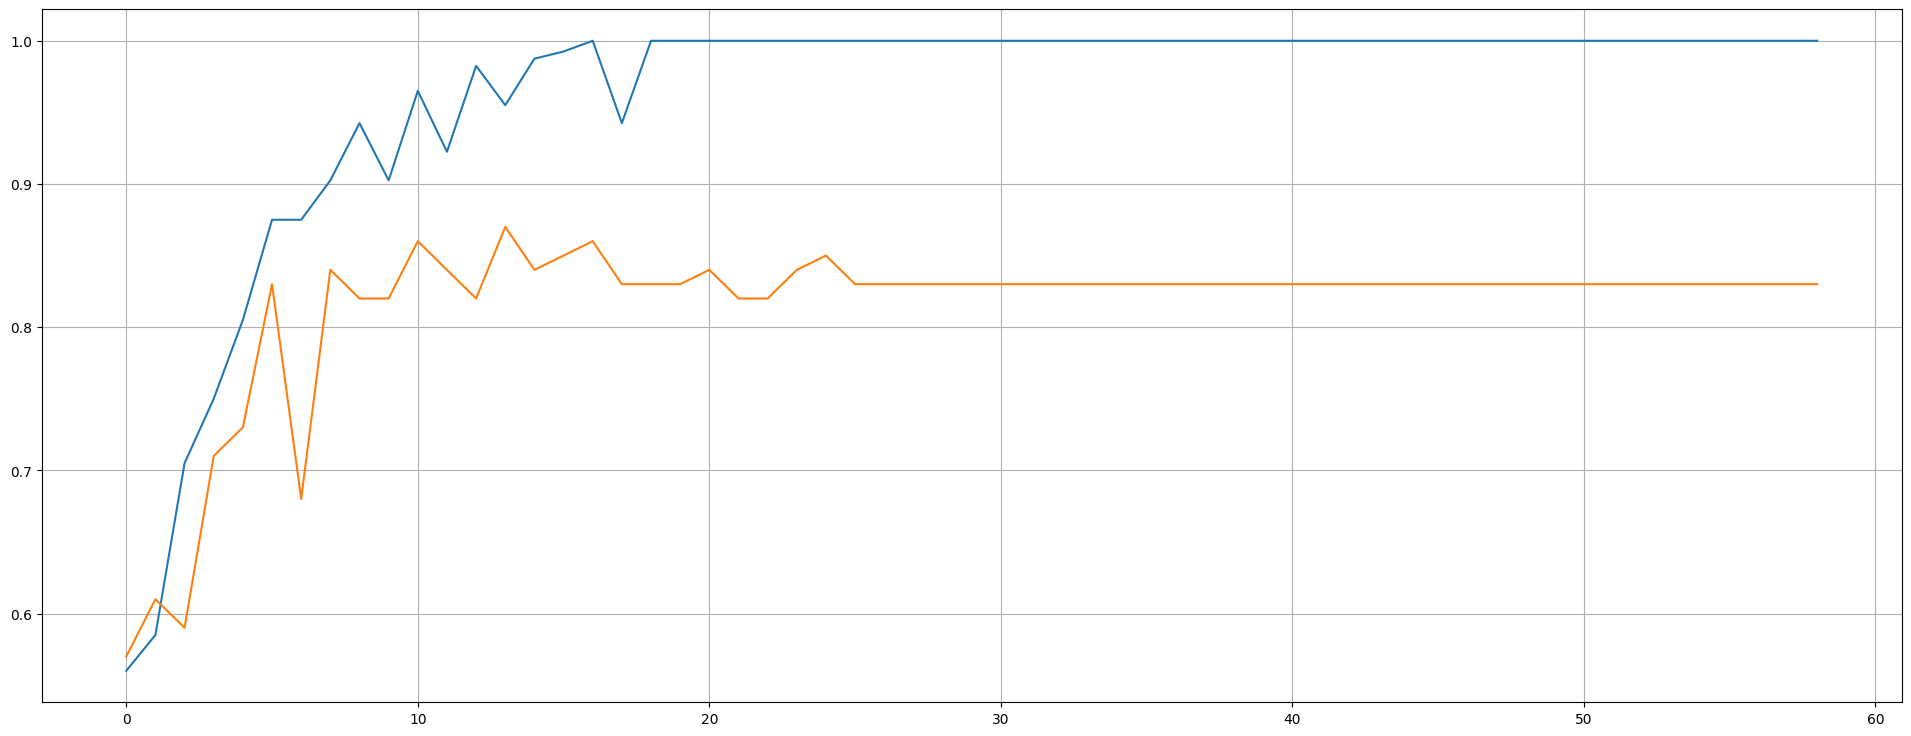

4/4 [==============================] - 1s 9ms/step
f1_score: 0.8470588235294119 acc: 0.87
32/32 [==============================] - 0s 11ms/step


In [12]:
true_y = []
pred_y = []

final_pred_y = []

nfolds=5
skf = StratifiedKFold(n_splits=nfolds, random_state=13, shuffle=True)

for i, (train_index, val_index) in enumerate(skf.split(samples, labels)):
    print()
    print()
    print(i,'=====================================================================================')
    
    train_samples = [samples[index] for index in train_index]
    val_samples   = [samples[index] for index in val_index]
    
    train_labels = [labels[index] for index in train_index]
    val_labels   = [labels[index] for index in val_index]
    
    
    
    vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
    text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128)
    vectorizer.adapt(text_ds)
    

    x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
    x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()
    x_test = vectorizer(np.array([[s] for s in test_samples])).numpy()


    y_train = np.array(train_labels)
    y_val = np.array(val_labels)    
    
    
    model = get_model(vectorizer)
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=45, restore_best_weights=True)

    
    
    history = model.fit(x_train, y_train, batch_size=32, epochs=575, 
                        validation_data=(x_val, y_val), callbacks=[callback], verbose=0)    
    """
    plt.figure(figsize=(24, 9))     
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.grid()
    plt.show()       
    """ 
    
    plt.figure(figsize=(24, 9))     
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.grid()    
    plt.show()       
    
   
    y_true = y_val
    y_pred = model.predict(x_val)
    y_Dpred = y_pred.argmax(axis=1)
    print('f1_score:',f1_score(y_true, y_Dpred), 'acc:', accuracy_score(y_true, y_Dpred))

    
    test_pred = model.predict(x_test)
    
    
    true_y = true_y + list(y_true).copy()  
    pred_y = pred_y + list(y_pred).copy()      

    
    final_pred_y.append(test_pred)
    
    
    vectorizer_weights = vectorizer.get_weights()
    with open('./models/vectorizer_fold_'+str(i)+'_weights.pickle', 'wb') as f:
        pickle.dump(vectorizer_weights, f)

        
    model.save('models/my_model_fold_'+str(i)+'.h5')   

In [13]:
final_preds = final_pred_y[0]
for i in range(1,len(final_pred_y)):
    final_preds = final_preds * final_pred_y[i]
final_preds = final_preds ** (1/len(final_pred_y))
print()    
print("=====================================================")        
print('final_preds shape', final_preds.shape)
final_preds = final_preds.argmax(axis=1)
print('final_preds shape', final_preds.shape)


final_preds shape (1000, 2)
final_preds shape (1000,)


In [14]:
#final_preds

In [15]:
test_data['label'] = final_preds
test_data

,id,title,text,label
0,11000,"RE: 555-PASSPORT, NAME NAME","NAME NAME. Для дополнительных консультаций, п...",0
1,11001,Анапа,# # # write your NAME NAME NAME line # # #:: 5...,0
2,11002,"RE: заявка гост. NAME, Анапа","NAME, добрый вечер! Не получила ваучер, Пионер...",0
3,11003,"FW: заявка гост. NAME, Анапа",Анна!пионерский NAME NAME Спасибо NAME С уваже...,0
4,11004,RE: билеты для NAME,"Ок С уважением, NAME NAME Менеджер по организа...",0
...,...,...,...,...
995,11995,Re: NAME NAME NAME,"Хорошо, берём NAME NAME NAME для iOS < NAME > ...",0
996,11996,RE: [ EXTERNAL ] RE: NAME номер приказа 6289 н...,"NAME, тогда жду до конца дня инфо от вас, как ...",1
997,11997,"RE: Ваучер к заказу 4587374: NAME NAME NAME, N...","Добрый день, NAME Я сразу же пошел поскандалил...",0
998,11998,"RE: Электронный билет: # 421-PASSPORT, NAME NA...","NAME, добрый день. NAME. Пришлите, пожалуйста,...",1


In [16]:
test_data.to_csv('./submissions/submission_LSTM.csv', index = False)

In [17]:
f1_score( true_y, list(np.array(pred_y).argmax(axis=1)))

0.851063829787234

In [18]:
f1_score( true_y, list(np.array(pred_y).argmax(axis=1)), average='micro')

0.874

In [19]:
accuracy_score( true_y, list(np.array(pred_y).argmax(axis=1)))

0.874

### Export an end-to-end model

In [20]:
string_input = keras.Input(shape=(1,), dtype="string")
final_preds = []
for i in range(5):
    
    with open('./models/vectorizer_fold_'+str(i)+'_weights.pickle', 'rb') as f:
        vectorizer_weights = pickle.load(f)
    
    vectorizer_weights = vectorizer.set_weights(vectorizer_weights)

    model = tf.keras.models.load_model('models/my_model_fold_'+str(i)+'.h5')   
    
    
    x = vectorizer(string_input)
    preds = model(x)
    end_to_end_model = keras.Model(string_input, preds)

    
    probabilities = end_to_end_model.predict(
        [['Группа поддержки продаж Департамент продаж ПАО « Аэрофлот »']])

    final_preds.append(probabilities)

    
preds = final_preds[0]
for i in range(1,len(final_preds)):
    preds = preds * final_preds[i]
preds = preds ** (1/len(final_preds))
print()    
print("=====================================================")        
print('preds shape', preds.shape)
#preds = preds.argmax(axis=1)
#print('preds shape', preds.shape)    
    
    
preds


1/1 [==============================] - 1s 532ms/step

preds shape (1, 2)


array([[0.85060674, 0.1391026 ]], dtype=float32)